<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/model_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt

In [2]:
n_repeats=1
n_splits=5

In [3]:
path_to_max_label="../content/max_label.csv"
path_to_app="../content/cleaned_application.csv"
cleaned_app_df=pd.read_csv(path_to_app,index_col=0)
max_df=pd.read_csv(path_to_max_label,index_col=0)

In [4]:
dep_var="status"
random_state=42

preprocessing the same as other model notebook.

In [5]:
order=cleaned_app_df.groupby("job")["income"].median().sort_values()

In [6]:
cleaned_app_df["job"]=cleaned_app_df["job"].replace(order)

In [7]:
train_df=max_df.merge(cleaned_app_df,how="inner",on="id").drop("id",axis=1)

In [8]:
numerical_transformer = StandardScaler()
categorical_transformer=OneHotEncoder()
ord_transformer=OrdinalEncoder()

In [9]:
X,y=train_df.drop(columns=dep_var),train_df[dep_var]

In [10]:
categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
                        X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('ord',ord_transformer,['job'])
    ])

In [12]:
xs=preprocessor.fit_transform(X)

In [13]:
score_df=pd.DataFrame()

cv same

In [14]:
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

In [15]:
# dataframe of scores to be converted into plot later
score_df=pd.DataFrame()

In [16]:
import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.utils.class_weight import compute_class_weight

In [17]:
def scheduler(epoch, lr):
          if epoch < 10:
            return lr
          else:
            return lr * tf.math.exp(-0.1)
schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
# montior is the loss, not metric, patience is personal heuristic
earlystop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
callbacks=[schedule,earlystop]
#Adam > SGD
opt = tf.optimizers.Adam(learning_rate=0.001)
#Use BinaryFocalCrossentropy instead of BinaryCrossentropy
loss= tf.keras.losses.BinaryFocalCrossentropy()
# we can use AUC and PR metric
metrics = [tf.keras.metrics.AUC(curve='ROC')]
def createModel(loss,optimizer,metrics):
    model= keras.Sequential([
      keras.layers.Dense(1024,activation="relu"),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(512,activation="relu"),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(256,activation="relu"),
      keras.layers.Dense(128,activation="relu"),
      keras.layers.Dense(1,activation="sigmoid")])
    model.compile(loss=loss,optimizer=opt, metrics=metrics)
    return model

In [18]:
bestscore=0
bestmodel,bestmodel_val_data=None,None
bestmodel_val_data=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      model= createModel(loss=loss,optimizer=opt, metrics=metrics)
      class_w= dict(zip(np.unique(y_train),compute_class_weight("balanced",classes=np.unique(y_train),y=y_train)))
      history=model.fit(X_train, y_train,batch_size=64, epochs=100,validation_data=(X_test,y_test),verbose=1,callbacks=callbacks,class_weight=class_w)
      y_pred = model.predict(X_test,verbose=0)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore,bestmodel_val_data=score,[y_test,X_test]
            print(f"NN with best score of {score}")
score_df["NN"]=scores
print(f"NN with avg score of {np.median(np.array(scores))}")

Epoch 1/100
285/285 [==============================] - 4s 11ms/step - loss: 0.1752 - auc: 0.5150 - val_loss: 0.1632 - val_auc: 0.5364 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 3s 12ms/step - loss: 0.1732 - auc: 0.5354 - val_loss: 0.1728 - val_auc: 0.5403 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 4s 13ms/step - loss: 0.1722 - auc: 0.5558 - val_loss: 0.1721 - val_auc: 0.5598 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 3s 12ms/step - loss: 0.1714 - auc: 0.5724 - val_loss: 0.1634 - val_auc: 0.5602 - lr: 0.0010
Epoch 5/100
285/285 [==============================] - 3s 12ms/step - loss: 0.1704 - auc: 0.5877 - val_loss: 0.1677 - val_auc: 0.5660 - lr: 0.0010
Epoch 6/100
285/285 [==============================] - 3s 12ms/step - loss: 0.1693 - auc: 0.6032 - val_loss: 0.1754 - val_auc: 0.5721 - lr: 0.0010
NN with best score of 0.5358146773445001
Epoch 1/100
285/285 [==============================] - 5s 12ms/step - loss: 0

570/570 [==============================] - 1s 2ms/step


<AxesSubplot:title={'center':'preds'}, xlabel='[ground_truth]'>

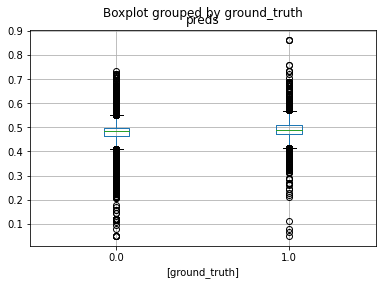

In [19]:
y_test,X_test=bestmodel_val_data
view=pd.DataFrame([model.predict(X_test).reshape(-1),y_test.values]).T
view.columns=["preds","ground_truth"]
view.boxplot(by='ground_truth')

In [20]:
# classes are balanced ,we use BCE
loss= keras.losses.BinaryCrossentropy()
earlystop=keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
callbacks=[schedule,earlystop]

In [21]:
score_df.to_csv("../content/score_nn.csv")

In [22]:
score_df_smote=pd.DataFrame()

In [23]:
bestscore=0
bestmodel,bestmodel_val_data=None,None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      model= createModel(loss=loss,optimizer=opt, metrics=metrics)
      sm=SMOTE()
      X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
      model.compile(loss=loss,optimizer=opt, metrics=metrics)
      # we do not compute classweights as the data is balanced
      history=model.fit(X_train_oversampled,y_train_oversampled,batch_size=64, epochs=100,validation_data=(X_test,y_test),verbose=1,callbacks=callbacks)
      y_pred = model.predict(X_test,verbose=0)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore,bestmodel_val_data=score,[y_test,X_test]
            print(f"NN with best score of {score}")
score_df_smote["NN_Smote"]=scores

Epoch 1/100
503/503 [==============================] - 5s 8ms/step - loss: 0.6772 - auc: 0.6131 - val_loss: 0.6455 - val_auc: 0.5718 - lr: 8.1873e-04
Epoch 2/100
503/503 [==============================] - 4s 7ms/step - loss: 0.5998 - auc: 0.7356 - val_loss: 0.5979 - val_auc: 0.6073 - lr: 8.1873e-04
Epoch 3/100
503/503 [==============================] - 4s 7ms/step - loss: 0.5185 - auc: 0.8189 - val_loss: 0.5705 - val_auc: 0.6308 - lr: 8.1873e-04
Epoch 4/100
503/503 [==============================] - 4s 7ms/step - loss: 0.4598 - auc: 0.8629 - val_loss: 0.5734 - val_auc: 0.6496 - lr: 8.1873e-04
Epoch 5/100
503/503 [==============================] - 4s 7ms/step - loss: 0.4224 - auc: 0.8859 - val_loss: 0.5205 - val_auc: 0.6470 - lr: 8.1873e-04
Epoch 6/100
503/503 [==============================] - 4s 7ms/step - loss: 0.3947 - auc: 0.9010 - val_loss: 0.5413 - val_auc: 0.6700 - lr: 8.1873e-04
Epoch 7/100
503/503 [==============================] - 4s 7ms/step - loss: 0.3709 - auc: 0.9128 - va

570/570 [==============================] - 1s 2ms/step


<AxesSubplot:title={'center':'preds'}, xlabel='[ground_truth]'>

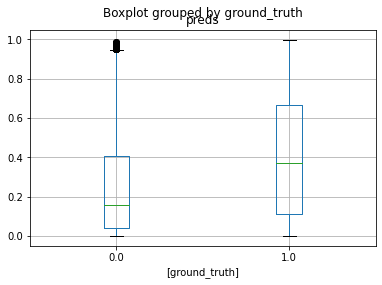

In [24]:
y_test,X_test=bestmodel_val_data
view=pd.DataFrame([model.predict(X_test).reshape(-1),y_test.values]).T
view.columns=["preds","ground_truth"]
view.boxplot(by='ground_truth')

In [25]:
score_df_smote.to_csv("../content/score_nn_smote.csv")

In [26]:
score_df_tl=pd.DataFrame()

In [27]:
bestscore=0
bestmodel,bestmodel_val_data=None,None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      model= createModel(loss=loss,optimizer=opt, metrics=metrics)
      tl=TomekLinks()
      X_train_undersampled, y_train_undersampled = tl.fit_resample(X_train, y_train)
      model.compile(loss=loss,optimizer=opt, metrics=metrics)
      history=model.fit(X_train_oversampled,y_train_oversampled,batch_size=64, epochs=100,validation_data=(X_test,y_test),verbose=1,callbacks=callbacks)
      y_pred = model.predict(X_test,verbose=0)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore,bestmodel_val_data=score,[y_test,X_test]
            print(f"NN with best score of {score}")
score_df_tl["NN_Smote"]=scores

Epoch 1/100
503/503 [==============================] - 5s 7ms/step - loss: 0.6750 - auc: 0.6965 - val_loss: 0.6935 - val_auc: 0.6519 - lr: 8.1873e-04
Epoch 2/100
503/503 [==============================] - 3s 7ms/step - loss: 0.6061 - auc: 0.7265 - val_loss: 0.5514 - val_auc: 0.7333 - lr: 8.1873e-04
Epoch 3/100
503/503 [==============================] - 3s 7ms/step - loss: 0.5251 - auc: 0.8120 - val_loss: 0.4654 - val_auc: 0.7999 - lr: 8.1873e-04
Epoch 4/100
503/503 [==============================] - 3s 7ms/step - loss: 0.4686 - auc: 0.8561 - val_loss: 0.3879 - val_auc: 0.8354 - lr: 8.1873e-04
Epoch 5/100
503/503 [==============================] - 3s 7ms/step - loss: 0.4271 - auc: 0.8824 - val_loss: 0.3697 - val_auc: 0.8541 - lr: 8.1873e-04
Epoch 6/100
503/503 [==============================] - 4s 7ms/step - loss: 0.3947 - auc: 0.9004 - val_loss: 0.3471 - val_auc: 0.8724 - lr: 8.1873e-04
Epoch 7/100
503/503 [==============================] - 3s 7ms/step - loss: 0.3743 - auc: 0.9111 - va

In [ ]:
y_test,X_test=bestmodel_val_data
view=pd.DataFrame([model.predict(X_test).reshape(-1),y_test.values]).T
view.columns=["preds","ground_truth"]
view.boxplot(by='ground_truth')

In [ ]:
score_df_tl.to_csv("../content/score_nn_tl.csv")